# Pyiron workflows: quickstart

You can start converting python functions to `pyiron_workflow` nodes by wrapping them with decorators accessible from our single-point-of-entry, the `Workflow` class:

In [1]:
from pyiron_workflow import Workflow

## From function to node

Let's start with a super simple function that only returns a single thing

In [2]:
@Workflow.wrap_as.single_value_node()
def AddOne(x):
    y = x + 1
    return y

node = AddOne()

This node object can be run just like the function it wraps

In [3]:
node(42)

43

But is also a class instance with input and output channels (note that here the output value takes its name based on what came after the `return` statement)

In [4]:
node.inputs.x = 0
node.run()
node.outputs.y.value

1

So other than being delayed, these nodes behave a _lot_ like the regular python functions that wrap them:

In [5]:
calculation = AddOne(AddOne(AddOne(2)))
calculation()

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:168: UserWarning: The channel run was not connected to ran, andthus could not disconnect from it.
  warn(


5

But they are actually nodes, and what we saw above is just syntactic sugar for building a _graph_ connecting the inputs and outputs of the nodes:

In [6]:
n1 = AddOne()
n2 = AddOne()
n3 = AddOne()

n2.inputs.x = n1.outputs.y
n3.inputs.x = n2.outputs.y

n1.inputs.x = 0
n3()

3

## Putting it together in a workflow

We can work with nodes all by themselves, but since the whole point is to connect them together to make a computation graph, we can get extra tools by intentionally making these children of a `Workflow` node.

The `Workflow` class not only gives us access to the decorators for defining new nodes, but also lets us register modules of existing nodes and use them. Let's put together a workflow that uses both an existing node from a package, and a `Function` node that is more general than we used above in that it allows us to have multiple return values. This function node will also exploit our ability to name outputs and give type hints. 

We can also take output channels (or single value nodes) and perform many (but not all...) python operations on them to dynamically create new output nodes! Below see how we do math and indexing right on the output channels:

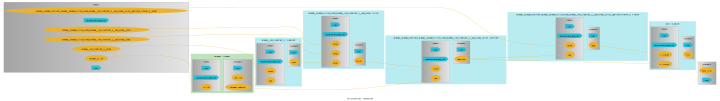

In [7]:
import numpy as np

wf = Workflow("my_workflow")

@Workflow.wrap_as.function_node("arange", "len")
def Arange(n: int) -> tuple[np.ndarray, int]:
    """
    Two outputs is silly overkill, but just to demonstrate how Function nodes work
    """
    return np.arange(n), n

wf.register("pyiron_workflow.node_library.plotting", "plotting")

wf.arange = Arange(10)
wf.plot = wf.create.plotting.Scatter(
    x=wf.arange.outputs.arange[:wf.arange.outputs.len -1],
    y=wf.arange.outputs.arange[:wf.arange.outputs.len -1]**2
)

wf.draw(size=(10,10))

We can see that the workflow automatically exposes unconnected IO of its children and gives them a name based on the child node's name and that node's IO name. Further, the math and indexing we do automatically injects new nodes after the output. Note that the slicing nodes get re-used in both occurrences for computational efficiency.

Let's run our workflow and look at the result:

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/node.py:767: UserWarning: The keyword 'arrays__x' was not found among input labels. If you are trying to update a node keyword, please use attribute assignment directly instead of calling
  warnings.warn(


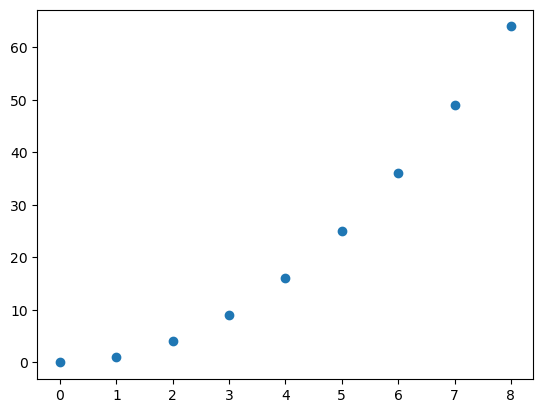

In [8]:
out = wf(arrays__x=5)
out.plot__fig

Unless it's turned off, `pyiron_workflow` will make sure that all new nodes and connections obey type hints (where provided). For instance, if we try to pass a non-int to our `square_range` node, we'll get an error:

In [9]:
try:
    wf.arange.inputs.x = 5.5
except TypeError as e:
    message = e.args[0]
    print(message)

Can only set Channel object or connect to existing channels, but the attribute x got assigned 5.5 of type <class 'float'>


## Composing complex workflows from macros

There's just one last step: once we have a workflow we're happy with, we can package it as a "macro"! This lets us make more and more complex workflows by composing sub-graphs.

We don't yet have an automated tool for converting workflows into macros, but we can create them by decorating a function that takes a macro instance and builds its graph, so we can just copy-and-paste our workflow above into a decorated function! 

We can also give our macro prettier IO names. This can be done with "maps" (which are also available on the workflows):

In [10]:
@Workflow.wrap_as.macro_node()
def MySquarePlot(macro):
    macro.arange = Arange()
    macro.plot = macro.create.plotting.Scatter(
        x=macro.arange.outputs.arange[:macro.arange.outputs.len -1],
        y=macro.arange.outputs.arange[:macro.arange.outputs.len -1]**2
    )
    macro.inputs_map = {"arange__n": "n"}
    macro.outputs_map = {
        "arange__arange": "x",
        "arange__len": "n",
        "plot__fig": "fig"
    }
    # Note that we also forced regularly hidden IO to be exposed!
    # We can also hide IO that's usually exposed by mapping to `None`
    # but that would be a lot of typing in this case

Or we can use a more function-node-like defintion of our macro with args and/or kwargs, and return values and output labels. The "maps" above _always take precedence_ so you still have full control over your macro-level IO, but using this format switches us over to an "whitelist" paradigm that automatically turns off all the other IO, which can make it easier to keep things tidy:

In [11]:
@Workflow.wrap_as.macro_node("x", "n", "fig")
def MySquarePlot(macro, n: int):
    macro.arange = Arange(n=n)
    macro.plot = macro.create.plotting.Scatter(
        x=macro.arange.outputs.arange[:macro.arange.outputs.len -1],
        y=macro.arange.outputs.arange[:macro.arange.outputs.len -1]**2
    )
    return macro.arange.outputs.arange, macro.arange.outputs.len, macro.plot

{'square_plot__n': 10,
 'square_plot__fig': <matplotlib.collections.PathCollection at 0x12ce7c150>,
 'plus_one_square_plot__fig': <matplotlib.collections.PathCollection at 0x12cfaaed0>}

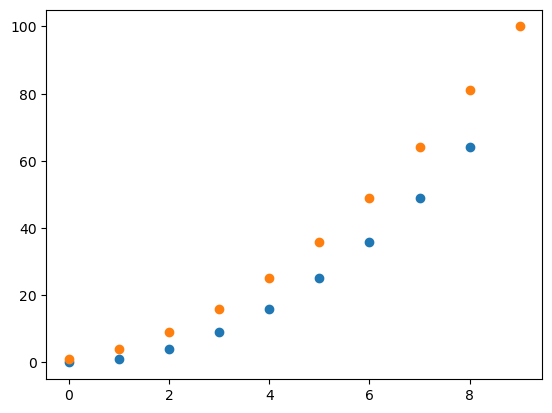

In [12]:
wf2 = Workflow("my_composed_workflow")

wf2.square_plot = MySquarePlot(n=10)
wf2.plus_one = wf2.square_plot.outputs.x + 1
wf2.plus_one_square_plot = wf2.create.plotting.Scatter(
    x=wf2.square_plot.outputs.x,
    y=wf2.plus_one**2,
)
wf2()

Meanwhile, we can see that our macro node IO is much tidier than the previous workflow IO now that when we're using the function-like definition, while the body of the graph is identical:

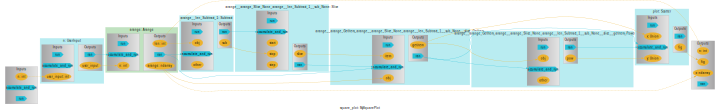

In [13]:
wf2.square_plot.draw(size=(10,10))

## What else?

To learn more, take a look at the `deepdive.ipynb` notebook, and/or start looking through the class docstrings. Here's a brief map of what you're still missing:

- Distributing node execution onto remote processes
  - Single core parallel python processes is available by setting the `.executor` attribute to a compatible executor instance, e.g. `Workflow.create.Executor()`
- Acyclic graphs
  - Execution for graphs whose data flow topology is a DAG happens automatically, but you're always free to specify this manually with `Signals`, and indeed _must_ specify the execution flow manually for cyclic graphs -- but cyclic graphs _are_ possible!
- Complex flow nodes
  - If, While, and For nodes are all available for more complex flow control
- Node libraries
  - Most of the current developments focus on running classical atomistics simulations
  
### Features coming shortly
- Storing workflow results and restarting partially executed workflows
- More and richer node packages

### Features planned
- "FAIR" principles for node packages and package registration
- Ontological typing and guided workflow design (see our `ironflow` project for a working prototype)